In [6]:
from config import logging
from scipy.stats import norm
import json
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [20]:

from yellowbrick.utils.kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from yellowbrick.cluster import KElbowVisualizer, KElbow
from yellowbrick.cluster.elbow import kelbow_visualizer
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [8]:
TDOA_REPORTS = os.getenv('TDOA_REPORTS', 'results/lufthansa24-04/asset_22_floor_2.json')
MILIMETER = int(os.getenv('MILIMETER',  1))

from config import (
    API_BASE,
    API_TOKEN,
    HTTP_TIMEOUT,
    MQTT_HOST,
    MQTT_PASS,
    MQTT_PORT,
    MQTT_USER,
)

In [9]:
measured_data = {}
tags = {}

try:
    f = open(TDOA_REPORTS)
    data = json.load(f)
except OSError as exc:
    logging.warning(f"Failed to open file: {exc}")
    sys.exit(1)

for entrence in data:
    if entrence['asset']['assetId'] is not None:
        uid = entrence['asset']['assetId']
    else:
        # if asset/ assetId doesnt exist save tag with uid
        uid = entrence.pop('id')

    # change the units from meter to millimeter
    if MILIMETER:
        entrence['pos']['x'] = int(entrence['pos']['x']*1000)
        entrence['pos']['y'] = int(entrence['pos']['y']*1000)
        try:
            for node in entrence['tdoadebug']:
                node['x'] = int(node['x']*1000)
                node['y'] = int(node['y']*1000)
                node['z'] = int(node['z']*1000)
        except:
            pass

    if uid not in tags:
        tags[uid] = [entrence]
    else:
        tags[uid].append(entrence)

for uid in tags: 
    tags[uid] = sorted(tags[uid], key=lambda k: k['time']) 

for uid in tags:
    for entrence in tags[uid]:
        if [sub['tdoa'] == 0.0 and sub['uid'] == '01aa2145cae48b16' for sub in entrence['tdoadebug']]:
            for tdoa_message in entrence['tdoadebug']:
                if tdoa_message['tdoa'] != 0:
                    if tdoa_message['uid'] in measured_data:
                        measured_data[tdoa_message['uid']].append(tdoa_message['tdoa'])
                    else:
                        measured_data[tdoa_message['uid']] = [tdoa_message['tdoa']]

In [10]:
# Code section for testing different kinde of algorithem to find the the number of clusters as well as the filtering the data in seperate clusters.

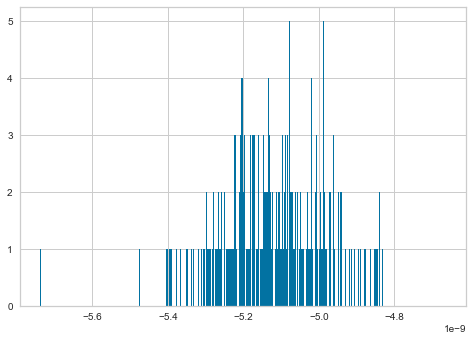

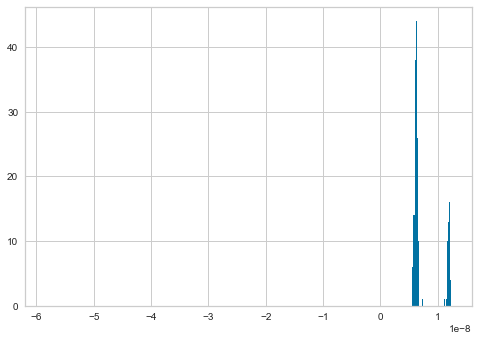

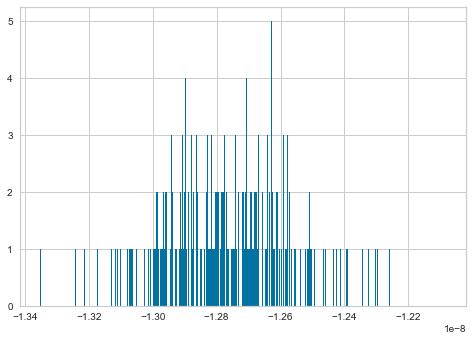

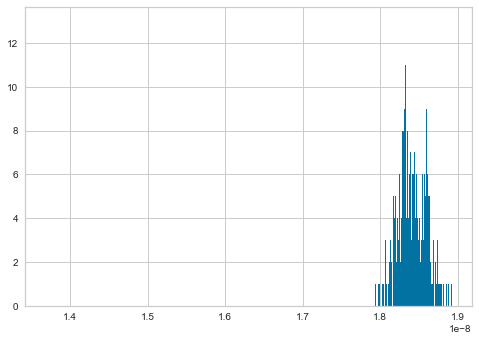

In [12]:
for uid in measured_data:

    fig, ax = plt.subplots()

    n, bins, patches = plt.hist(measured_data[uid], 1000 ,label= uid )

    plt.show()

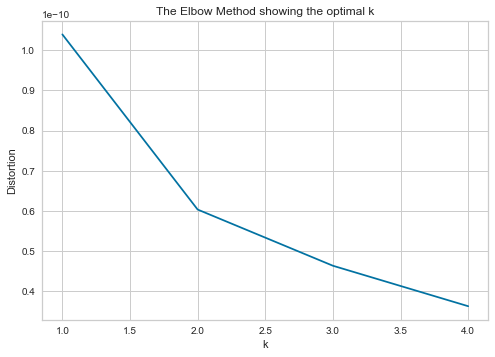

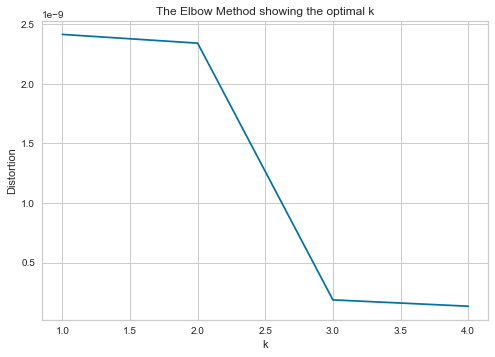

KeyboardInterrupt: 

In [13]:
for uid in measured_data:

    data = np.array([measured_data[uid]]).T

    distortions = []
    K = range(1,5)
    
    for k in K:
        kmeanModel = KMeans(n_clusters=k, max_iter=1).fit(data)
        # kmeanModel.fit(test)
        distortions.append(sum(np.min(cdist(data, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / data.shape[0])

    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

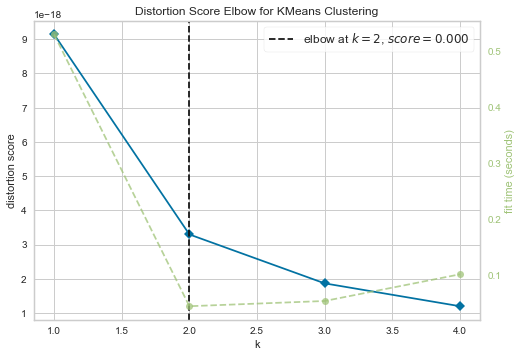

C:\Users\Daniel\.virtualenvs\jupiterNotebook-ozgfytBv\lib\site-packages\yellowbrick\utils\kneed.py:155: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Daniel\.virtualenvs\jupiterNotebook-ozgfytBv\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


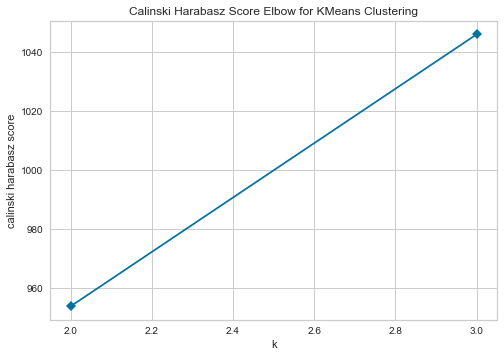

C:\Users\Daniel\.virtualenvs\jupiterNotebook-ozgfytBv\lib\site-packages\yellowbrick\utils\kneed.py:155: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Daniel\.virtualenvs\jupiterNotebook-ozgfytBv\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


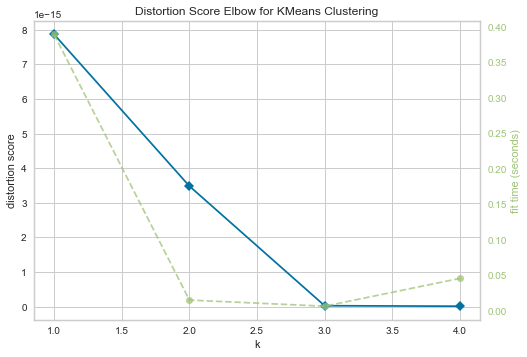

C:\Users\Daniel\.virtualenvs\jupiterNotebook-ozgfytBv\lib\site-packages\yellowbrick\utils\kneed.py:155: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Daniel\.virtualenvs\jupiterNotebook-ozgfytBv\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


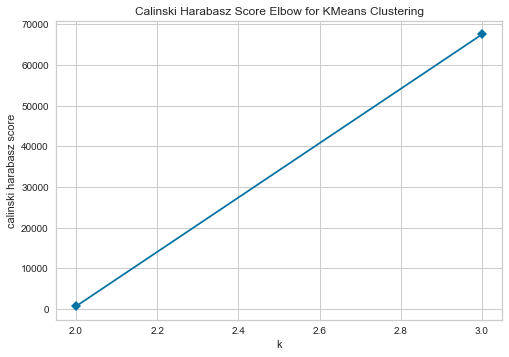

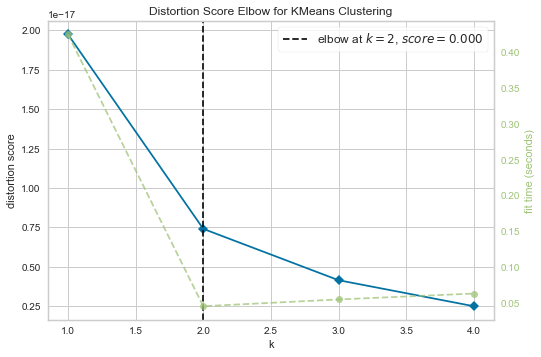

C:\Users\Daniel\.virtualenvs\jupiterNotebook-ozgfytBv\lib\site-packages\yellowbrick\utils\kneed.py:155: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Daniel\.virtualenvs\jupiterNotebook-ozgfytBv\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


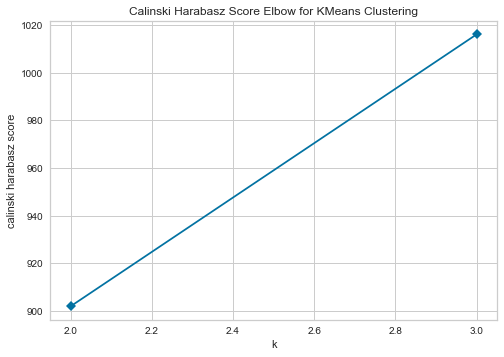

C:\Users\Daniel\.virtualenvs\jupiterNotebook-ozgfytBv\lib\site-packages\yellowbrick\utils\kneed.py:155: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Daniel\.virtualenvs\jupiterNotebook-ozgfytBv\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


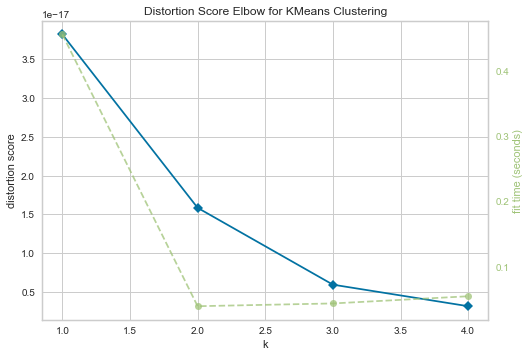

C:\Users\Daniel\.virtualenvs\jupiterNotebook-ozgfytBv\lib\site-packages\yellowbrick\utils\kneed.py:155: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Daniel\.virtualenvs\jupiterNotebook-ozgfytBv\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


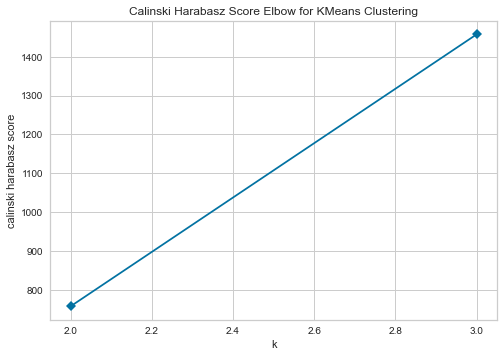

In [ ]:
for uid in measured_data:
    
    data = np.array([measured_data[uid]]).T
    
    # Instantiate the clustering model and visualizer
    model = KMeans()

    visualizer = KElbowVisualizer(
        model, k=(2,4), metric='calinski_harabasz', timings=False, locate_elbow=True
        )
        # if uid == '01aa2145caf203b4':
        #     for value in measured_data[uid]:
        #         if value < 0:
        #             measured_data[uid].remove(value)
        #             # -5.8408445191560077e-08
        #             # 1.1850900483167948e-08
        
    kelbow_visualizer(KMeans(random_state=4), data, k=(1,5))
    visualizer.fit(data)        # Fit the data to the visualizer
    visualizer.show()        # Finalize and render the figure  

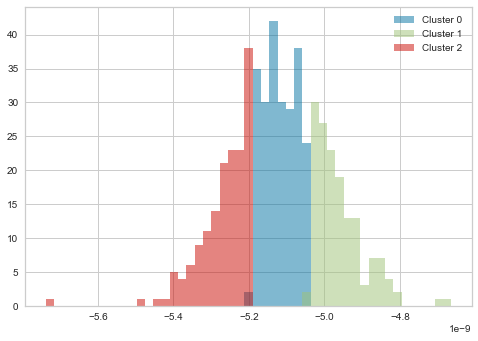

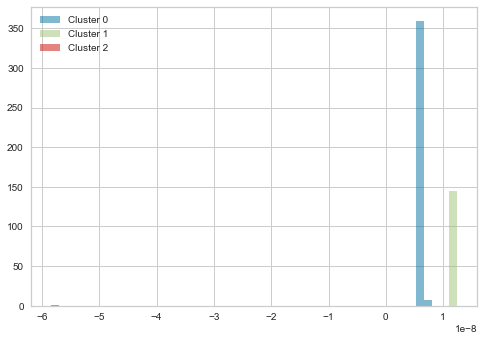

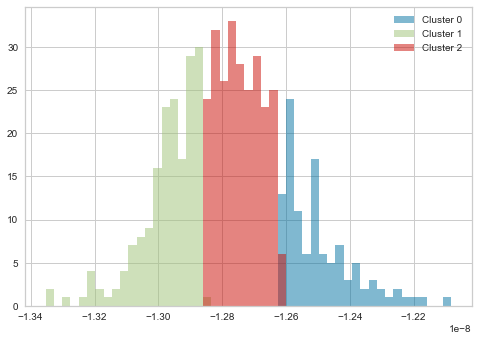

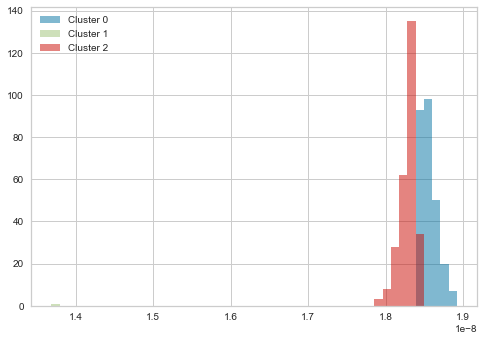

In [ ]:
for uid in measured_data:
    
    # # if uid == '01aa2145caf203b4':
    # #     for value in measured_data[uid]:
    # #         if value < 0:
    # #             measured_data[uid].remove(value)
    # #             # -5.8408445191560077e-08
    # #             # 1.1850900483167948e-08

    data = np.array([measured_data[uid]]).T

    cluster_id = KMeans(3).fit_predict(data)
    fig, ax = plt.subplots()
    bins = np.linspace(data.min(), data.max())
    for ii in np.unique(cluster_id):
        subset = data[cluster_id==ii]
        ax.hist(subset, bins=bins, alpha=0.5, label=f"Cluster {ii}")
    ax.legend()
    plt.show()

In [14]:
for uid in measured_data:
    
    # # if uid == '01aa2145caf203b4':
    # #     for value in measured_data[uid]:
    # #         if value < 0:
    # #             measured_data[uid].remove(value)
    # #             # -5.8408445191560077e-08
    # #             # 1.1850900483167948e-08

    data = np.array([measured_data[uid]]).T

    for i,k in enumerate([2,3,4,5]):
        
        # Run the kmeans algorithm
        km = KMeans(n_clusters=k)
        y_predict = km.fit_predict(data)
        centroids  = km.cluster_centers_


In [ ]:
# 3 types of methods to find the the rankings of different combinations of cluster.
# 1. silhoutte_score
# 2. calinski harabasz score
# 3. davies bouldin score

In [ ]:
score1 = {}
score2 = {}
score3 = {}

for uid in measured_data:
    
    # # if uid == '01aa2145caf203b4':
    # #     for value in measured_data[uid]:
    # #         if value < 0:
    # #             measured_data[uid].remove(value)
    # #             # -5.8408445191560077e-08
    # #             # 1.1850900483167948e-08

    data = np.array([measured_data[uid]]).T

    score1.update({ uid: [] })
    score2.update({ uid: [] })
    score3.update({ uid: [] })

    for i,k in enumerate([2,3,4,5]):

        # Run the kmeans algorithm
        km = KMeans(n_clusters=k)
        y_predict = km.fit_predict(data)
        centroids  = km.cluster_centers_
        score1[uid].append(silhouette_score(data, km.labels_, metric='euclidean'))
        score2[uid].append(calinski_harabasz_score(data, km.labels_))
        score3[uid].append(davies_bouldin_score(data, km.labels_))
    
    
    fig, ax = plt.subplots(1,3,figsize=(15,5))

    ax[0].plot([2,3,4,5], score1[uid])
    ax[0].set_title('silhouette_score')
    ax[1].plot([2,3,4,5], score2[uid])
    ax[1].set_title('calinski_harabasz_score')
    ax[2].plot([2,3,4,5], score3[uid])
    ax[2].set_title('davies_bouldin_score')

    plt.show()

# Acutelle state for k means clustering

In [27]:
score = {}

for uid in measured_data:

    data = np.array([measured_data[uid]]).T
    
    score.update({ uid: [] })
    km = []

    # kreate k-means and locate elbows
    for i,k in enumerate([1,2,3,4,5]):
        km.append(KMeans(n_clusters=k, max_iter=1))
        km[i].fit(data)
        score[uid].append({'cluster_error':km[i].inertia_, 'cluster_num': k})

    cluster_num = [value['cluster_num'] for value in score[uid]]
    cluster_error = [value['cluster_error'] for value in score[uid]]
    location = KneeLocator(cluster_num, cluster_error, S=1.83, curve_nature='convex', curve_direction='decreasing')

    # check if k-means has multiple clusters
    if location.knee:

        subset = []
        standard_dev = []
        new_tdoa = 6.5e-9

        cluster_id = km[location.elbow-1].predict(data)

        cluster_centers = km[location.elbow-1].cluster_centers_

        fig, ax = plt.subplots()

        bins = np.linspace(data.min(), data.max(), 1000)

        for ii, cluster_center in enumerate(cluster_centers):

            # create a subset of the data
            subset.append(data[cluster_id==ii])
            
            # calculate standard deviation for subset
            standard_dev.append(np.std(subset[ii]))

            # create histogram
            ax.hist(subset[ii], bins=bins, alpha=0.5, label=f"Cluster {ii}")

            # check if the new tdoa signal is in in bound of 3 standard deviation
            if (new_tdoa < cluster_center[0] + standard_dev[0] * 3 and
                new_tdoa > cluster_center[0] - standard_dev[0] * 3):
                
                if cluster_center < cluster_centers.max():
                    #TODO
                    pass

        plt.show()

        ax.legend()
        plt.show()

        plt.axvline(x=location.knee, linestyle='-.', color='k')

    plt.plot(cluster_num, cluster_error)
    plt.show()

C:\Users\Daniel\.virtualenvs\jupiterNotebook-ozgfytBv\lib\site-packages\yellowbrick\utils\kneed.py:155: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Daniel\.virtualenvs\jupiterNotebook-ozgfytBv\lib\site-packages\yellowbrick\utils\kneed.py:155: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Daniel\.virtualenvs\jupiterNotebook-ozgfytBv\lib\site-packages\yellowbrick\utils\kneed.py:155: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)


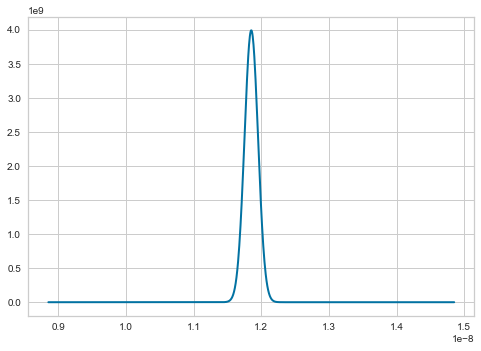

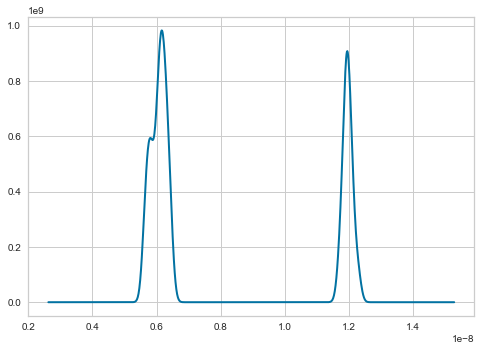

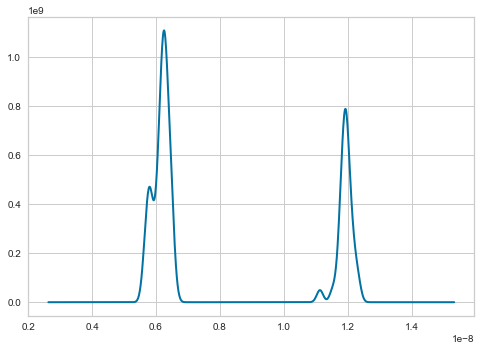

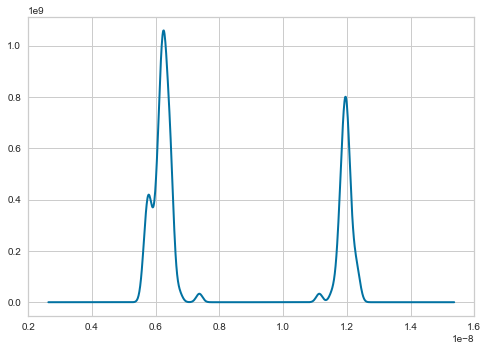

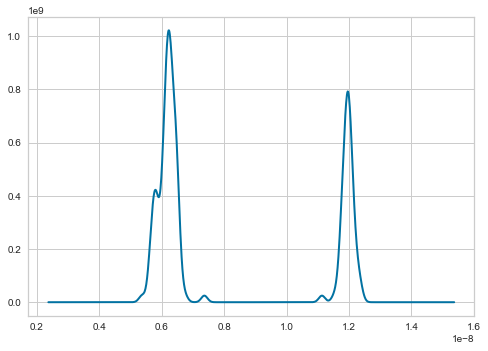

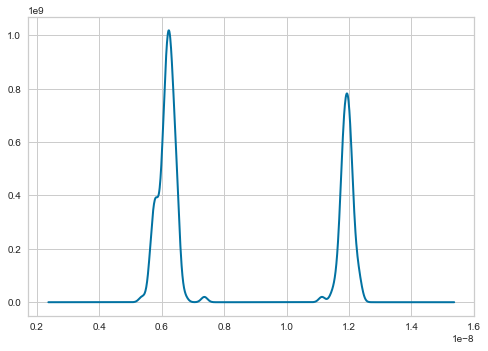

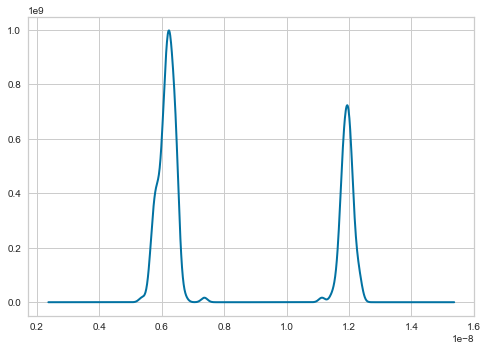

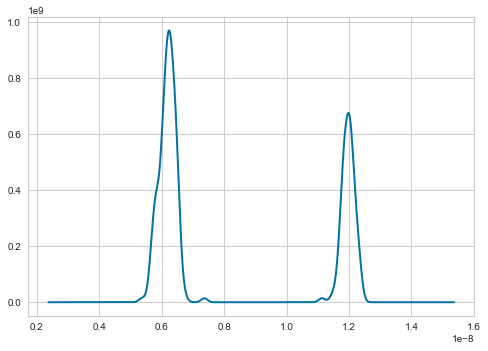

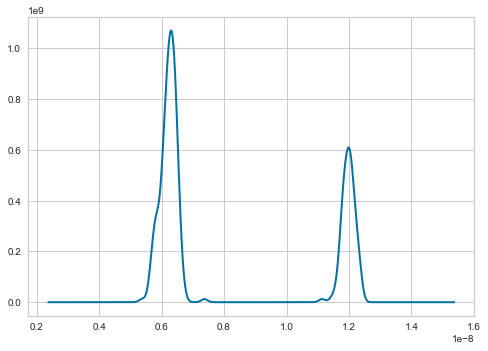

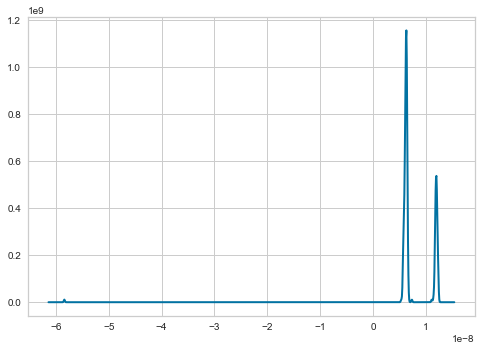

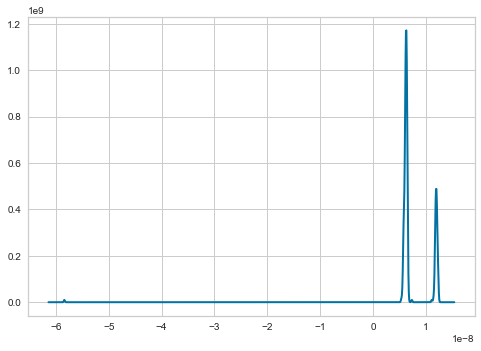

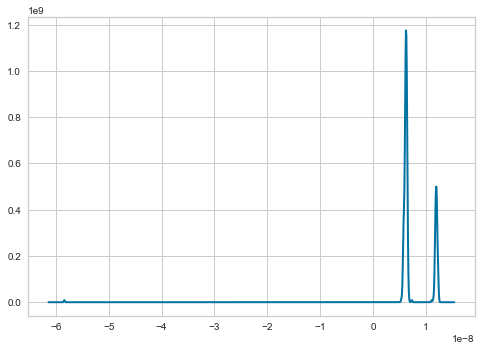

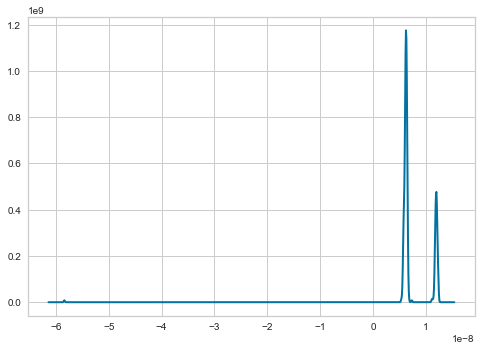

In [33]:
# for uid in measured_data:
uid = '01aa2145caf203b4'
liste = []
for i, value in enumerate(measured_data[uid]):

    liste.append(value)

    data = np.array([liste]).T

    kde = KernelDensity(kernel='gaussian', bandwidth=1e-10).fit(data)

    if (i % 40) == 0:
        lw = 2
        X_plot = np.linspace(data.min()-3e-9, data.max()+3e-9, 1000)[:, np.newaxis]
        log_dens = kde.score_samples(X_plot)
        plt.plot(X_plot[:, 0], np.exp(log_dens), lw=lw,
                linestyle='-', label="kernel = 'gaussian'")
        test = X_plot[:,0]
        plt.show()

# Kernel Density Estimation
try to get all modes and anitmodes by solving the 2 derivation. In this following codesegment I tried to solv the first and second derivation and plot all 3 graphs

In [ ]:
for uid in measured_data:
    liste = []
    for i, value in enumerate(measured_data[uid]):

        liste.append(value)

        data = np.array([liste]).T

        kde = KernelDensity(kernel='gaussian', bandwidth=1e-10).fit(data)


        if (i % 10) == 0:
            lw = 2
            X_plot = np.linspace(data.min()-3e-9, data.max()+3e-9, 1000)[:, np.newaxis]
        
            diff1 = np.gradient(kde.score_samples(X_plot))
            diff2 = np.gradient(diff1)
            kde1 = np.diff(kde.score_samples(X_plot))
            kde2 = np.diff(kde1)
            log_dens = kde.score_samples(X_plot)
            plt.plot(X_plot[:, 0], np.exp(log_dens), lw=lw,
                    linestyle='-', label="kernel = 'gaussian'")
            test = X_plot[:,0]
            plt.show()
            
            plt.plot(X_plot[:,0], diff1)
            plt.show()
            plt.plot(X_plot[:,0], diff2)
            plt.show()